## Task1 -- (Classifier evaluation)

In [2]:
import numpy
import urllib
import scipy.optimize
import random
from math import exp
from math import log

def parseData(fname):
  for l in urllib.urlopen(fname):
    yield eval(l)

print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("done")


Reading data...
done


### 1.Split the data into training, validation, and test sets, via 1/3, 1/3, 1/3 splits. Use random splits of the data 

In [317]:
data_random = data
random.shuffle(data_random)
train = data_random[:len(data_random)/3]
test = data_random[len(data_random)/3:len(data_random)*2/3]
validation = data_random[len(data_random)*2/3:]

In [318]:
def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

X = [feature(d) for d in train]
y = [d['beer/ABV'] >= 6.5 for d in train]


In [319]:
X_train = X
y_train = y

X1 = [feature(a) for a in test]
y1 = [a['beer/ABV'] >= 6.5 for a in test]
X2 = [feature(b) for b in validation]
y2 = [b['beer/ABV'] >= 6.5 for b in validation]


In [322]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]: #??
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])


In [323]:
def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta


In [324]:
def performance1(theta):
  scores = [inner(theta,x) for x in X1]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y1)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

In [325]:
def performance2(theta):
  scores = [inner(theta,x) for x in X2]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y2)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

In [326]:
lam = 1.0
theta = train(lam)
acc = performance1(theta)
print("test:" + "lambda = " + str(lam) + ":\taccuracy=" + str(acc))

test:lambda = 1.0:	accuracy=0.7189056218875622


In [17]:
lam = 1.0
theta = train(lam)
acc = performance2(theta)
print("validation:" + "lambda = " + str(lam) + ":\taccuracy=" + str(acc))

validation:lambda = 1.0:	accuracy=0.7232255354892902


the accuracy of the classifier on the validation set is 0.7232255354892902 and test set is 0.7184856302873942.

### 2.Report the number of Positives, Negatives, True Positives, True Negatives, False Positives, and False Negatives using the test set of the classifier you trained above (1 mark).

In [31]:
def performance3(theta):
  scores = [inner(theta,x) for x in X_train]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y_train)]
  acc = sum(correct) * 1.0 / len(correct)
  pre = predictions
  return pre

y_pre = performance3(theta)

In [32]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_train, y_pre)
cnf_matrix

array([[3000, 3318],
       [1391, 8957]])

Positives: 4381

Negatives: 12275

True Positives: 3000

True Negatives: 8957

False Positives: 1381

False Negatives: 3318

### 3.Describe how you would modify the code stub provided if you wanted to assign greater importance to False Positives compared to False Negatives. 

Because the loglikehood is the cost for the Negative result, so we can add a constant which is more than 1 to this fuction, in order to assign greater importance to False Positives.

In [333]:
# NEGATIVE Log-likelihood
def f1(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]: #??
      loglikelihood -= log(10) * logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime1(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k] *log(10)
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])


In [332]:
log(10)

2.302585092994046

In [334]:
def train1(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f1, [0]*len(X[0]), fprime1, pgtol = 10, args = (X_train, y_train, lam))
  return theta

lam = 1.0
theta = train1(lam)

In [337]:
def performance3(theta):
  scores = [inner(theta,x) for x in X_train]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y_train)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

y_pre1 = performance3(theta)
y_pre1

0.5123004920196808

### 4.Implement a training/validation/test pipeline so that you can select the best model based on its performance on the validation set. Try models with λ ∈ {0, 0.01, 0.1, 1, 100}. Report the performance on the training/validation/test sets for the best value of λ (1 mark).

In [33]:
def performance(theta):
  scores1 = [inner(theta,x) for x in X_train]
  scores2 = [inner(theta,x) for x in X1]
  scores3 = [inner(theta,x) for x in X2]  
  predictions1 = [s > 0 for s in scores1]
  predictions2 = [s > 0 for s in scores2]
  predictions3 = [s > 0 for s in scores3]
  correct1 = [(a==b) for (a,b) in zip(predictions1,y_train)]
  correct2 = [(a==b) for (a,b) in zip(predictions2,y1)]
  correct3 = [(a==b) for (a,b) in zip(predictions3,y2)]
  acc1 = sum(correct1) * 1.0 / len(correct1)
  acc2 = sum(correct2) * 1.0 / len(correct2)
  acc3 = sum(correct3) * 1.0 / len(correct3)
  dic = {"train":acc1,"test":acc2,"validation":acc3}
  return dic

In [34]:
lambdas = [0, 0.01, 0.1, 1, 100]
for lam in lambdas:
    theta = train(lam)
    acc = performance(theta)
    print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 0:	accuracy={'test': 0.7184256314873703, 'train': 0.7170886835473419, 'validation': 0.7227455450890982}
lambda = 0.01:	accuracy={'test': 0.7184856302873942, 'train': 0.7170886835473419, 'validation': 0.7227455450890982}
lambda = 0.1:	accuracy={'test': 0.7184856302873942, 'train': 0.7172086883475339, 'validation': 0.7227455450890982}
lambda = 1:	accuracy={'test': 0.7184856302873942, 'train': 0.7174486979479179, 'validation': 0.7232255354892902}
lambda = 100:	accuracy={'test': 0.6697066058678827, 'train': 0.6675867034681388, 'validation': 0.6773864522709546}


## Task2 -- (Community Detection)

### 5. How many connected components are in the graph, and how many nodes are in the largest connected component (1 mark)?

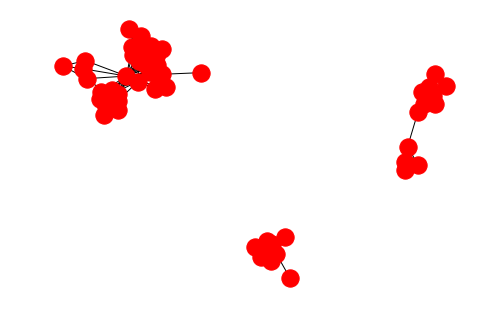

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

edges = set()
nodes = set()
for edge in urllib.urlopen("http://jmcauley.ucsd.edu/cse255/data/facebook/egonet.txt", 'r'):
  x,y = edge.split()
  x,y = int(x),int(y)
  edges.add((x,y))
  edges.add((y,x))
  nodes.add(x)
  nodes.add(y)

G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

In [12]:
nx.number_connected_components(G)

3

In [18]:
Cop = list(nx.connected_components(G))
len(Cop[0])

40

There are 3 connected components in the graph, and 40 nodes in the largest component.

### Next we’ll implement a ‘greedy’ version of normalized cuts, using just the largest connected component found above. First, split it into two equal halves, just by taking the 50% of nodes with the lowest and 50% with the highest IDs.

In [281]:
R = sorted(list(Cop[0]))
small = R[:20]
large = R[20:]


small_community = small[:]
large_community = large[:]

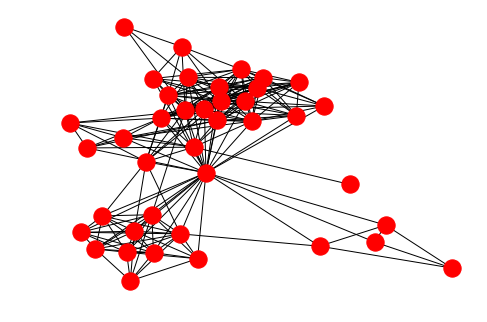

In [282]:
H = G.subgraph(R)
nx.draw(H)
plt.show()
plt.clf()

### 6. What is the normalized-cut cost of the 50/50 split you found above (1 mark)?

In [275]:
nx.normalized_cut_size(H,small,large)/2

0.4224058769513316

### 7.What are the elements of the split, and what is its normalized cut cost (1 mark)?

In [283]:
def move(x1,x2,y1,y2):
    Cost = {}
    for i in range(len(x1)):
        index1 = x1[i]
        y2.append(index1)
        x2.remove(index1)
        Cost[str(index1)+" 1 TO 2"] = nx.normalized_cut_size(H,x2,y2)/2
        x2.append(index1)
        y2.remove(index1)
    for i in range(len(y1)):
        index2 = y1[i]
        x2.append(index2)
        y2.remove(index2)
        Cost[str(index2)+" 2 TO 1"] = nx.normalized_cut_size(H,x2,y2)/2
        y2.append(index2)
        x2.remove(index2)
    return Cost

In [284]:
move(small,small_community,large,large_community)

{'697 1 TO 2': 0.4411369509043928,
 '703 1 TO 2': 0.41988216745498297,
 '708 1 TO 2': 0.4320413436692507,
 '713 1 TO 2': 0.4504560402059937,
 '719 1 TO 2': 0.4548837978661815,
 '729 1 TO 2': 0.3873319662793347,
 '745 1 TO 2': 0.4420141262246525,
 '747 1 TO 2': 0.45910039463625285,
 '753 1 TO 2': 0.42378673957621327,
 '769 1 TO 2': 0.4372670807453416,
 '772 1 TO 2': 0.4338349766476388,
 '774 1 TO 2': 0.4411369509043928,
 '798 1 TO 2': 0.426614399799829,
 '800 1 TO 2': 0.4548837978661815,
 '803 1 TO 2': 0.41674472824163694,
 '804 1 TO 2': 0.3873319662793347,
 '805 1 TO 2': 0.44578612190885786,
 '810 1 TO 2': 0.43766578249336874,
 '811 1 TO 2': 0.42470160871821483,
 '819 1 TO 2': 0.4322557961572667,
 '823 2 TO 1': 0.3948717948717949,
 '825 2 TO 1': 0.44254463163188335,
 '828 2 TO 1': 0.39084740683661895,
 '830 2 TO 1': 0.401664402173913,
 '840 2 TO 1': 0.40572337042925277,
 '856 2 TO 1': 0.4467346448612415,
 '861 2 TO 1': 0.4405657792111975,
 '863 2 TO 1': 0.4550827423167849,
 '864 2 TO 1

In [285]:
cost=[]

for i in range(0,20):
    result = move(small,small_community,large,large_community)
    a = min(result.items(),key = lambda x: x[1])[0]
    cost.append(result[a])
    
    if a[4] == '1':
        small_community.remove(int(a[0:3]))
        large_community.append(int(a[0:3]))

    if a[4] == '2':
        small_community.append(int(a[0:3]))
        large_community.remove(int(a[0:3]))
        
    small = small_community[:]
    large = large_community[:]

In [310]:
min(cost)

0.09817045961624274

In [289]:
small_community,large_community

([697,
  703,
  708,
  713,
  719,
  745,
  747,
  753,
  769,
  772,
  774,
  800,
  803,
  805,
  810,
  811,
  819,
  828,
  823,
  830,
  840,
  880,
  890,
  869,
  856,
  798],
 [825, 861, 863, 864, 876, 878, 882, 884, 886, 888, 889, 893, 804, 729])

### 8. Re-implement your greedy algorithm above so that it maximizes the modularity, rather than the normalized cut cost. Report modularity values for the 50/50 split you find (1 mark).

In [302]:
R = sorted(list(Cop[0]))
small = R[:20]
large = R[20:]

small_community = small[:]
large_community = large[:]

In [303]:
def move(x1,x2,y1,y2):
    Modularity = {}
    for i in range(len(x1)):
        index1 = x1[i]
        y2.append(index1)
        x2.remove(index1)
        Modularity[str(index1)+" 1 TO 2"] = nx.algorithms.community.modularity(H,[x2,y2])
        x2.append(index1)
        y2.remove(index1)
    for i in range(len(y1)):
        index2 = y1[i]
        x2.append(index2)
        y2.remove(index2)
        Modularity[str(index2)+" 2 TO 1"] = nx.algorithms.community.modularity(H,[x2,y2])
        y2.append(index2)
        x2.remove(index2)
    return Modularity

In [304]:
move(small,small_community,large,large_community)

{'697 1 TO 2': 0.05883264462809917,
 '703 1 TO 2': 0.07979338842975216,
 '708 1 TO 2': 0.06792355371900828,
 '713 1 TO 2': 0.049493801652892584,
 '719 1 TO 2': 0.04508264462809923,
 '729 1 TO 2': 0.112386363636364,
 '745 1 TO 2': 0.05784090909090909,
 '747 1 TO 2': 0.04089876033057848,
 '753 1 TO 2': 0.0760227272727273,
 '769 1 TO 2': 0.06260330578512388,
 '772 1 TO 2': 0.06585743801652885,
 '774 1 TO 2': 0.05883264462809915,
 '798 1 TO 2': 0.07271694214876036,
 '800 1 TO 2': 0.04508264462809923,
 '803 1 TO 2': 0.08263429752066132,
 '804 1 TO 2': 0.11238636363636399,
 '805 1 TO 2': 0.054173553719008234,
 '810 1 TO 2': 0.06214876033057847,
 '811 1 TO 2': 0.07494834710743806,
 '819 1 TO 2': 0.06767561983471075,
 '823 2 TO 1': 0.10165289256198388,
 '825 2 TO 1': 0.056652892561983456,
 '828 2 TO 1': 0.10536157024793433,
 '830 2 TO 1': 0.09570247933884342,
 '840 2 TO 1': 0.09189049586776894,
 '856 2 TO 1': 0.05040289256198356,
 '861 2 TO 1': 0.05825413223140503,
 '863 2 TO 1': 0.04396694214

In [305]:
modularity=[]

for i in range(0,20):
    result = move(small,small_community,large,large_community)
    a = max(result.items(),key = lambda x: x[1])[0]
    cost.append(result[a])
    
    if a[4] == '1':
        small_community.remove(int(a[0:3]))
        large_community.append(int(a[0:3]))

    if a[4] == '2':
        small_community.append(int(a[0:3]))
        large_community.remove(int(a[0:3]))
        
    small = small_community[:]
    large = large_community[:]

In [306]:
max(modularity)

0.3380165289256198